In [1]:
import os 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [2]:
BASE_DIR='data'

data_train='data/train/'
data_validasi='data/validation/'

train_acral='data/train/acral_lentiginous_melanoma'
train_blue_finger='data/train/blue_finger'
train_clubbing='data/train/clubbing'
train_healthy_nail='data/train/healthy_nail'
train_onychogryphosis='data/train/onychogryphosis'
train_pitting='data/train/pitting'

validation_acral='data/validation/acral_lentiginous_melanoma'
validation_blue_finger='data/validation/blue_finger'
validation_clubbing='data/validation/clubbing'
validation_healthy_nail='data/validation/healthy_nail'
validation_onychogryphosis='data/validation/onychogryphosis'
validation_pitting='data/validation/pitting'

print(f"Contents of base directory: {os.listdir(BASE_DIR)}")

print(f"\nContents of train directory: {os.listdir(data_train)}")

print(f"\nContents of validation directory: {os.listdir(data_validasi)}")


Contents of base directory: ['train', 'validation']

Contents of train directory: ['acral_lentiginous_melanoma', 'blue_finger', 'clubbing', 'healthy_nail', 'onychogryphosis', 'pitting']

Contents of validation directory: ['Acral_Lentiginous_Melanoma', 'blue_finger', 'clubbing', 'Healthy_Nail', 'Onychogryphosis', 'pitting']


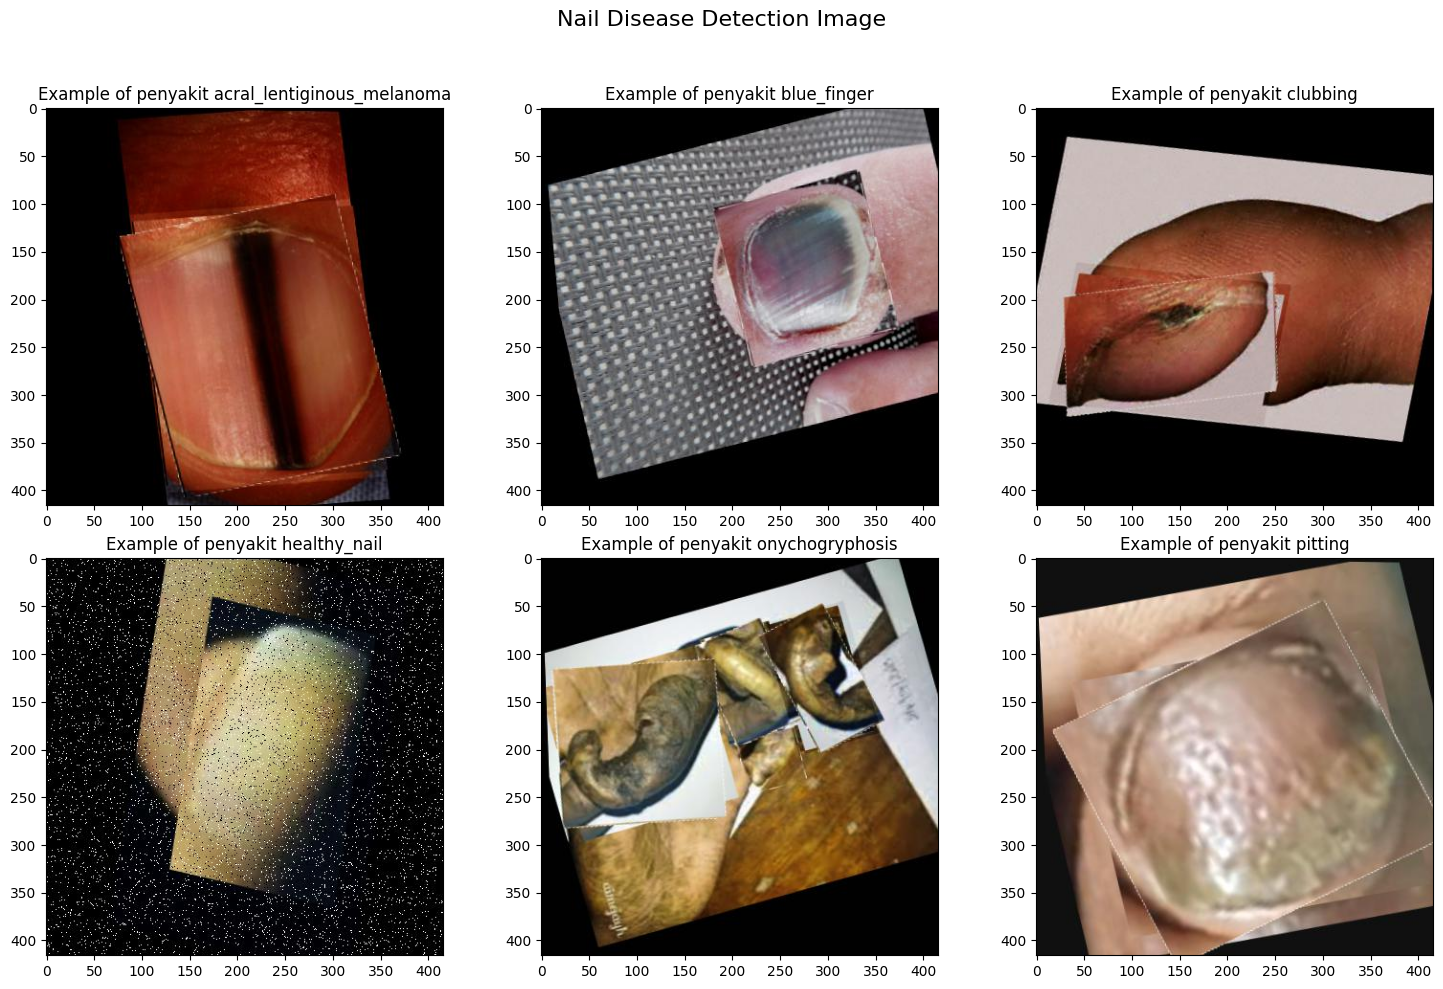

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Nail Disease Detection Image', fontsize=16)

for ii, penyakit in enumerate(('acral_lentiginous_melanoma',
                               'blue_finger', 
                               'clubbing', 
                               'healthy_nail',
                               'onychogryphosis',
                               'pitting'
                               )):
    dir = f'./data/train/{penyakit}'
    img = tf.keras.preprocessing.image.load_img(dir + '/' + os.listdir(dir)[0])
    row, col = divmod(ii, 3)  # menentukan baris dan kolom berdasarkan indeks
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of penyakit {penyakit}')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Memberikan ruang untuk judul utama
plt.show()

In [4]:
sample_array=tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has size: {sample_array.shape}")

Each image has size: (416, 416, 3)


In [5]:
sample_array[0,:5]

array([[16., 16., 16.],
       [16., 16., 16.],
       [16., 16., 16.],
       [16., 16., 16.],
       [16., 16., 16.]], dtype=float32)

In [6]:
#create model
def create_model():
    model=tf.keras.models.Sequential([
        tf.keras.Input(shape=(300,300,3)),
        tf.keras.layers.Rescaling(1./255),
        
        tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
        loss='categorical_crossentropy',
        metrics=['accuracy'] 
    )
    return model


In [7]:
BATCH_SIZE=32
IMAGE_SIZE=(300,300)
LABEL_MODE='categorical'

#Inisiasi Dataset
# train_dataset,validation_dataset=tf.keras.utils.image_dataset_from_directory(
#     data_train,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode=LABEL_MODE,
#     validation_split=0.2, #20% data untuk validasi
#     subset='both',
#     seed=42 
# )

# train_dataset=tf.keras.utils.image_dataset_from_directory(
#     data_train,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode=LABEL_MODE
# )

# validation_dataset=tf.keras.utils.image_dataset_from_directory(
#     data_validasi,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode=LABEL_MODE
# )



Found 3744 files belonging to 6 classes.
Found 91 files belonging to 6 classes.


In [54]:
#Optimasi
SHUFFLE_BUFFER_SIZE=1000
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

train_dataset_final=(
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

validation_dataset_final=(
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)


In [55]:


class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.95 and validation accuracy is greater or equal to 0.8
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if train_accuracy >= 0.95 and val_accuracy >= 0.8:
            self.model.stop_training = True

            print("\nReached 95% train accuracy and 80% validation accuracy, so cancelling training!")



In [56]:
#base model
base_model = create_model()

# Constant for epochs
EPOCHS = 50

# Train the model
history = base_model.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_dataset_final,
      callbacks = [EarlyStoppingCallback()])


Epoch 1/50
32/94 ━━━━━━━━━━━━━━━━━━━━ 44s 716ms/step - accuracy: 0.1685 - loss: 43.0738

KeyboardInterrupt: 

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

NameError: name 'history' is not defined

overfitting cuy

#### Menggunakan augmentasi

In [ ]:
FILL_MODE='nearest'

data_augmentation=tf.keras.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
])

In [ ]:
base_model=create_model()
model_with_aug=tf.keras.models.Sequential([
    data_augmentation,
    base_model
])

model_with_aug.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [ ]:
# Constant for epochs
EPOCHS = 20

# Train the model
history_aug = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=2,
      validation_data = validation_dataset_final)

Epoch 1/20
94/94 - 64s - 676ms/step - accuracy: 0.2310 - loss: 1.7578 - val_accuracy: 0.2794 - val_loss: 1.7064
Epoch 2/20
94/94 - 60s - 634ms/step - accuracy: 0.2810 - loss: 1.6807 - val_accuracy: 0.3195 - val_loss: 1.5973
Epoch 3/20
94/94 - 59s - 625ms/step - accuracy: 0.3318 - loss: 1.5862 - val_accuracy: 0.2420 - val_loss: 1.6118
Epoch 4/20
94/94 - 54s - 572ms/step - accuracy: 0.3818 - loss: 1.4740 - val_accuracy: 0.3783 - val_loss: 1.4766
Epoch 5/20
94/94 - 55s - 588ms/step - accuracy: 0.4162 - loss: 1.4048 - val_accuracy: 0.4037 - val_loss: 1.3496
Epoch 6/20
94/94 - 54s - 570ms/step - accuracy: 0.4262 - loss: 1.3729 - val_accuracy: 0.4666 - val_loss: 1.2840
Epoch 7/20
94/94 - 55s - 590ms/step - accuracy: 0.4383 - loss: 1.3361 - val_accuracy: 0.2473 - val_loss: 1.9143
Epoch 8/20
94/94 - 52s - 558ms/step - accuracy: 0.4473 - loss: 1.3147 - val_accuracy: 0.4051 - val_loss: 1.4458
Epoch 9/20
94/94 - 52s - 553ms/step - accuracy: 0.4553 - loss: 1.3041 - val_accuracy: 0.3971 - val_loss:

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    fig.suptitle('Without Augmentation', fontsize=16)
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

In [ ]:
def plot_loss_acc(history_aug):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history_aug.history['accuracy']
    val_acc = history_aug.history['val_accuracy']
    loss = history_aug.history['loss']
    val_loss = history_aug.history['val_loss']

    epochs = range(len(acc))

    fig1, ax = plt.subplots(1,2, figsize=(12, 6))
    fig1.suptitle('With Augmentation', fontsize=16)
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

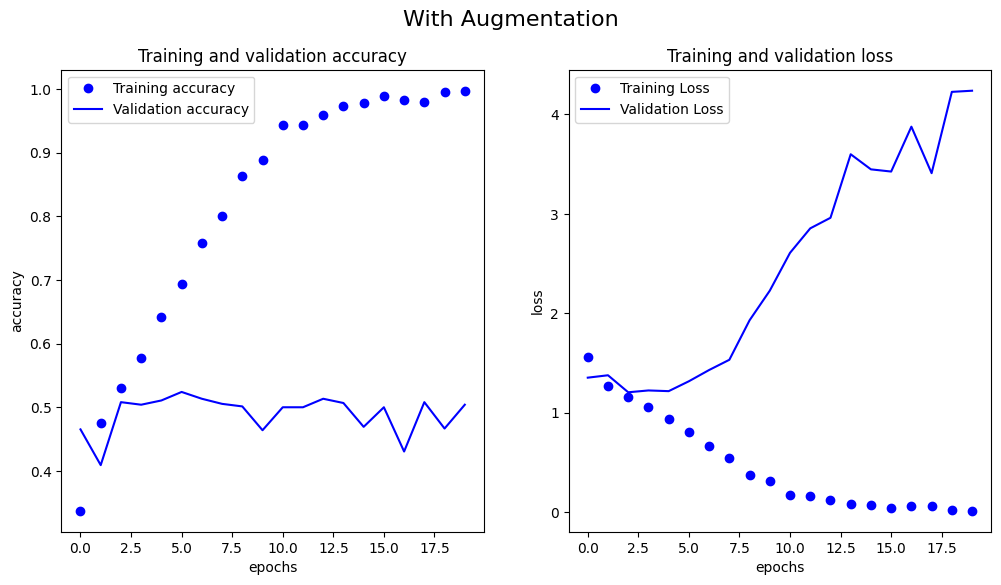

In [ ]:
plot_loss_acc(history)

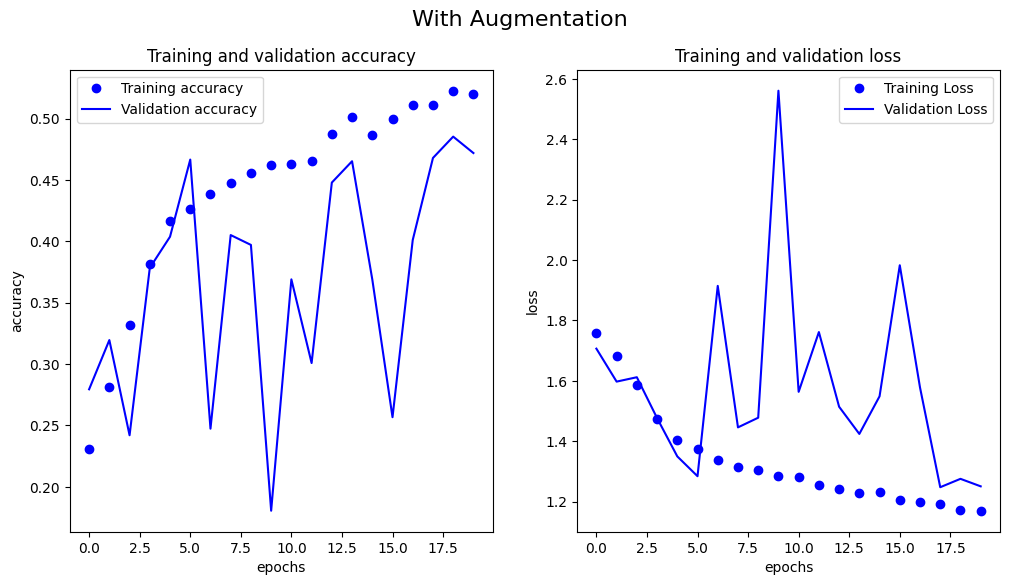

In [ ]:
plot_loss_acc(history_aug)

## Gambar Pertama
### Accuracy (Akurasi)
Akurasi pada data pelatihan meningkat tajam, mencapai hampir 100% pada akhir pelatihan.
Namun, akurasi pada data validasi tetap rendah dan stagnan sekitar 50%, menunjukkan adanya overfitting yang kuat. Model sangat cocok pada data pelatihan tetapi tidak generalisasi dengan baik pada data validasi.
### Loss (Kehilangan)
Loss pada data pelatihan terus menurun, mencapai hampir nol, yang menunjukkan bahwa model sangat sesuai dengan data pelatihan.
Namun, loss pada data validasi meningkat setelah beberapa epoch, yang merupakan indikasi overfitting. Model tampaknya tidak berhasil menangkap pola pada data validasi, hanya mengingat pola pada data pelatihan.

## Gambar Kedua
### Accuracy (Akurasi)
Akurasi pada data pelatihan mengalami peningkatan secara bertahap, namun tetap berada di bawah 60% bahkan pada akhir pelatihan.
Akurasi pada data validasi menunjukkan fluktuasi yang sangat besar, yang mengindikasikan bahwa model kesulitan dalam belajar dari data augmented ini dan mungkin terlalu sensitif terhadap variasi dalam data validasi.
### Loss (Kehilangan)
Loss pada data pelatihan menurun secara bertahap, tetapi tidak mencapai nilai yang sangat rendah, yang menunjukkan bahwa model tidak terlalu overfitted seperti pada gambar pertama.
Namun, loss pada data validasi sangat fluktuatif, dengan beberapa puncak tinggi, yang menunjukkan bahwa model mungkin mengalami underfitting. Ini mungkin karena model tidak mampu belajar dengan baik dari data yang beragam akibat augmentasi.

## Kesimpulan
- Overfitting di Gambar Pertama: Model sangat fit pada data pelatihan tetapi tidak generalisasi dengan baik pada data validasi, yang sering terjadi ketika data augmentasi tidak cukup beragam atau model terlalu kompleks untuk dataset yang digunakan.
- Underfitting dan Variabilitas Tinggi di Gambar Kedua: Pada gambar kedua, model tampaknya kurang fit terhadap data pelatihan dan tidak mampu menangkap pola yang stabil pada data validasi, kemungkinan disebabkan oleh augmentasi berlebihan atau arsitektur model yang kurang tepat.

## Rekomendasi
- Untuk Gambar Pertama: Tambahkan regularisasi, kurangi kompleksitas model, atau perbaiki augmentasi agar model dapat lebih generalisasi.
- Untuk Gambar Kedua: Kurangi intensitas augmentasi atau optimalkan hyperparameter untuk menangkap pola yang lebih stabil dalam data.